In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# ==========================================
# 1. LOAD DATASET
# ==========================================
print("=== 1. MEMUAT DATA ===")
df = pd.read_csv('Data_Panel_Final_Siap_Regresi.csv')

# Pastikan tidak ada data kosong
df = df.dropna()

# Definisikan Variabel
Y = df['stock_return']
X = df[['volume', 'volatility', 'market_return']]
X = sm.add_constant(X)  # Tambahkan konstanta (Intercept)

# Tampilkan Statistik Deskriptif (Untuk Bab 4 - Gambaran Data)
print("\n[Statistik Deskriptif Variabel]")
desc_stats = df[['stock_return', 'volume', 'volatility', 'market_return']].describe().T
print(desc_stats[['mean', 'std', 'min', 'max']])



=== 1. MEMUAT DATA ===

[Statistik Deskriptif Variabel]
                       mean           std           min           max
stock_return   4.441586e-03  1.131822e-01 -6.093671e-01  7.088955e-01
volume         1.205111e+09  1.398471e+09  1.690000e+06  2.118000e+10
volatility     8.914367e-02  6.868566e-02  1.291796e-03  5.698230e-01
market_return  6.447547e-03  4.232699e-02 -1.834196e-01  9.022143e-02
------------------------------------------------------------


In [ ]:
# ==========================================
# 2. ESTIMASI MODEL (COMMON EFFECT / OLS)
# ==========================================
print("\n=== 2. HASIL REGRESI COMMON EFFECT MODEL (CEM) ===")
model_cem = sm.OLS(Y, X)
hasil_cem = model_cem.fit()

print(hasil_cem.summary())



=== 2. HASIL REGRESI COMMON EFFECT MODEL (CEM) ===
                            OLS Regression Results                            
Dep. Variable:           stock_return   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     174.7
Date:                Sun, 30 Nov 2025   Prob (F-statistic):          1.48e-100
Time:                        02:34:25   Log-Likelihood:                 1754.0
No. Observations:                2001   AIC:                            -3500.
Df Residuals:                    1997   BIC:                            -3478.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [4]:
# ==========================================
# 3. VALIDASI PEMILIHAN MODEL (Why CEM?)
# ==========================================
print("\n=== 3. VALIDASI PEMILIHAN MODEL ===")

# --- A. Uji Chow (Manual F-Test: Fixed Effect vs Common Effect) ---
# Kita perlu menjalankan Fixed Effect (Least Square Dummy Variable) sebentar untuk perbandingan
# Menggunakan Dummy Variables untuk setiap emiten
X_fe = pd.get_dummies(df['emiten'], drop_first=True)
X_fe = pd.concat([X, X_fe], axis=1)
# Konversi boolean (True/False) menjadi integer (1/0)
X_fe = X_fe.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

model_fe = sm.OLS(Y, X_fe).fit()
rss_cem = hasil_cem.ssr  # Residual Sum of Squares CEM
rss_fem = model_fe.ssr   # Residual Sum of Squares FEM
N = df['emiten'].nunique()
T = df.groupby('emiten')['date'].count().mean()
k = 3 # Jumlah variabel independen

# Rumus F-Statistik Chow
chow_stat = ((rss_cem - rss_fem) / (N - 1)) / (rss_fem / (df.shape[0] - N - k))
chow_pval = 1 - stats.f.cdf(chow_stat, N - 1, df.shape[0] - N - k)

print(f">> Uji Chow (CEM vs FEM):")
print(f"   F-Stat: {chow_stat:.4f}, Prob: {chow_pval:.4f}")
if chow_pval > 0.05:
    print("   Kesimpulan: Terima H0 (Pilih COMMON EFFECT).")
else:
    print("   Kesimpulan: Tolak H0 (Pilih FIXED EFFECT).")

# --- B. Uji LM (Breusch-Pagan: Random Effect vs Common Effect) ---
df['resid'] = hasil_cem.resid
A = (df.groupby('emiten')['resid'].sum() ** 2).sum()
B = (df['resid'] ** 2).sum()
lm_stat = (N * T / (2 * (T - 1))) * ((A / B) - 1) ** 2
lm_pval = 1 - stats.chi2.cdf(lm_stat, df=1)

print(f"\n>> Uji LM (CEM vs REM):")
print(f"   LM-Stat: {lm_stat:.4f}, Prob: {lm_pval:.4f}")
if lm_pval > 0.05:
    print("   Kesimpulan: Terima H0 (Pilih COMMON EFFECT).")
else:
    print("   Kesimpulan: Tolak H0 (Pilih RANDOM EFFECT).")

print("-" * 60)




=== 3. VALIDASI PEMILIHAN MODEL ===
>> Uji Chow (CEM vs FEM):
   F-Stat: 0.9945, Prob: 0.4733
   Kesimpulan: Terima H0 (Pilih COMMON EFFECT).

>> Uji LM (CEM vs REM):
   LM-Stat: 1.4802, Prob: 0.2237
   Kesimpulan: Terima H0 (Pilih COMMON EFFECT).
------------------------------------------------------------


In [ ]:
# ==========================================
# 4. UJI ASUMSI KLASIK (Karena CEM = OLS)
# ==========================================
print("\n=== 4. UJI ASUMSI KLASIK ===")

# A. Uji Multikolinearitas (VIF)
print("\n>> A. Uji Multikolinearitas (VIF)")
vif_data = pd.DataFrame()
vif_data["Variabel"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)
print("   (Catatan: VIF < 10 artinya aman dari multikolinearitas)")

# B. Uji Heteroskedastisitas (Breusch-Pagan)
print("\n>> B. Uji Heteroskedastisitas (Breusch-Pagan)")
lm_het, p_het, f_het, fp_het = het_breuschpagan(hasil_cem.resid, X)
print(f"   LM Stat: {lm_het:.4f}")
print(f"   P-Value: {p_het:.4f}")
if p_het > 0.05:
    print("   Kesimpulan: Gagal Tolak H0 (Data Homoskedastis / Aman).")
else:
    print("   Kesimpulan: Tolak H0 (Ada Heteroskedastisitas).")
    print("   Solusi: Gunakan 'Robust Standard Errors' (cov_type='HC1') di regresi.")


=== 4. UJI ASUMSI KLASIK ===

>> A. Uji Multikolinearitas (VIF)
        Variabel       VIF
0          const  3.008772
1         volume  1.067460
2     volatility  1.066591
3  market_return  1.000921
   (Catatan: VIF < 10 artinya aman dari multikolinearitas)

>> B. Uji Heteroskedastisitas (Breusch-Pagan)
   LM Stat: 487.5912
   P-Value: 0.0000
   Kesimpulan: Tolak H0 (Ada Heteroskedastisitas).
   Solusi: Gunakan 'Robust Standard Errors' (cov_type='HC1') di regresi.

>> C. Cek Output Summary Regresi:
   - Jarque-Bera (Prob): Jika < 0.05 tidak normal (Wajar untuk data saham).
   - Durbin-Watson: Nilai sekitar 2 (1.5 - 2.5) artinya bebas autokorelasi.


In [ ]:
# ==========================================
# 2. ESTIMASI MODEL ROBUST (SOLUSI HETEROSKEDASTISITAS)
# ==========================================
print("\n=== 2. HASIL REGRESI CEM (ROBUST STANDARD ERRORS) ===")
# Menggunakan cov_type='HC1' untuk mengatasi Heteroskedastisitas
model_cem = sm.OLS(Y, X)
hasil_cem = model_cem.fit(cov_type='HC1') 

print(hasil_cem.summary())


=== 2. HASIL REGRESI CEM (ROBUST STANDARD ERRORS) ===
                            OLS Regression Results                            
Dep. Variable:           stock_return   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     103.4
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           1.83e-43
Time:                        02:37:55   Log-Likelihood:                 1754.0
No. Observations:                2001   AIC:                            -3500.
Df Residuals:                    1997   BIC:                            -3478.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

c:\Users\Azalia Fitriana B\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


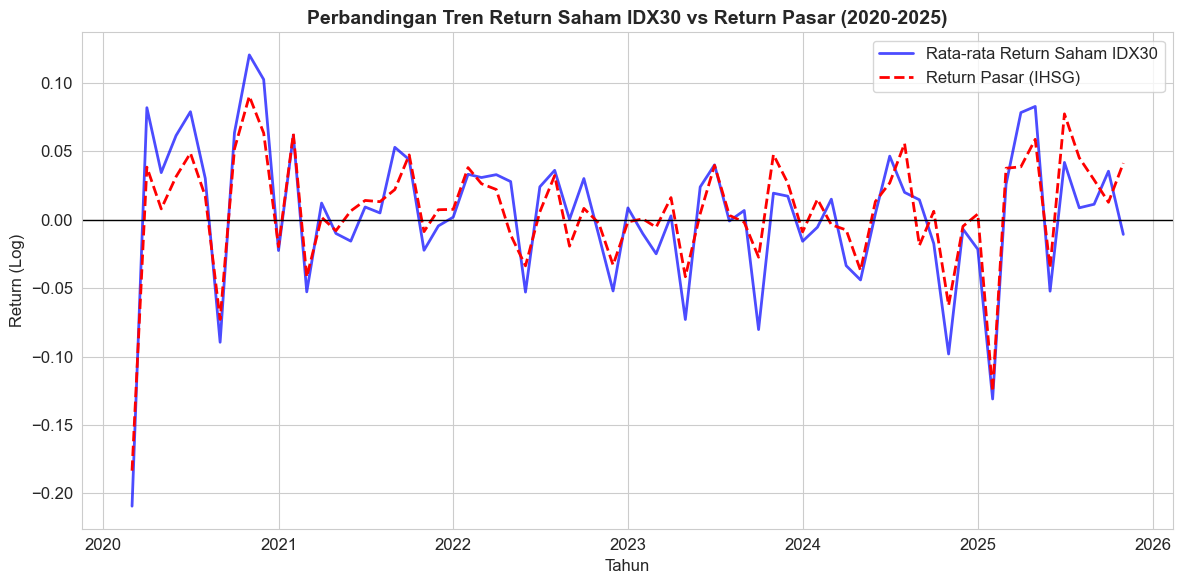

Interpretasi Grafik 1:
Grafik ini menunjukkan bahwa pergerakan return saham IDX30 sangat berimpitan (seirama)
dengan pergerakan pasar (IHSG). Ketika garis merah turun, garis biru ikut turun.
Ini memvalidasi hasil regresi bahwa Market Return berpengaruh signifikan.
--------------------------------------------------


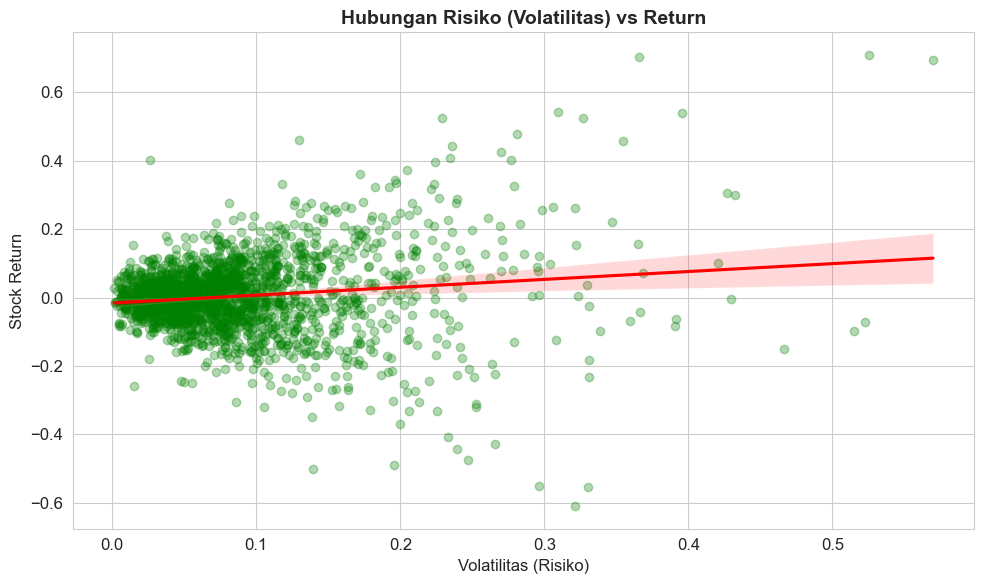

Interpretasi Grafik 2:
Garis merah yang menanjak ke kanan atas menunjukkan korelasi POSITIF.
Semakin ke kanan (Volatilitas tinggi), titik-titik data cenderung naik (Return tinggi).
Ini adalah bukti visual teori 'High Risk High Return'.
--------------------------------------------------


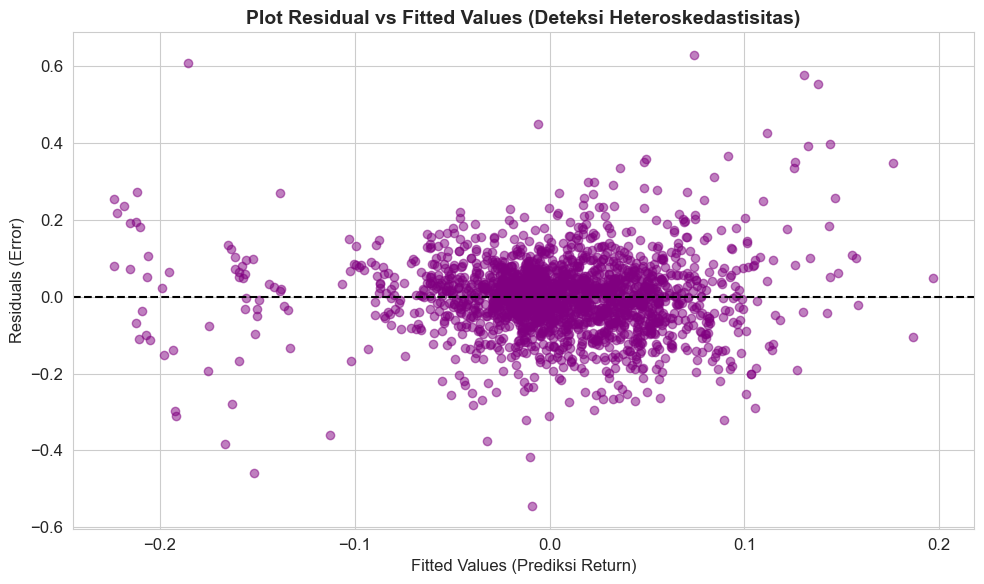

Interpretasi Grafik 3:
Perhatikan pola sebaran titik-titik ungu.
Jika menyebar tidak merata (misal: melebar di kanan/kiri atau membentuk corong),
itu tandanya ada Heteroskedastisitas.
Grafik inilah alasan visual kenapa kamu harus menggunakan metode 'Robust Standard Errors'.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 1. Load Data
df = pd.read_csv('Data_Panel_Final_Siap_Regresi.csv')
df['date'] = pd.to_datetime(df['date'])

# Set Style biar grafik terlihat akademis tapi modern
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# ==========================================
# GRAFIK 1: TREN RATA-RATA RETURN IDX30 vs IHSG
# ==========================================
# Kita hitung rata-rata return seluruh saham per bulan
monthly_avg = df.groupby('date')[['stock_return', 'market_return']].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg['stock_return'], label='Rata-rata Return Saham IDX30', color='blue', linewidth=2, alpha=0.7)
plt.plot(monthly_avg.index, monthly_avg['market_return'], label='Return Pasar (IHSG)', color='red', linestyle='--', linewidth=2)

plt.title('Perbandingan Tren Return Saham IDX30 vs Return Pasar (2020-2025)', fontsize=14, fontweight='bold')
plt.xlabel('Tahun')
plt.ylabel('Return (Log)')
plt.legend()
plt.axhline(0, color='black', linewidth=1) # Garis nol
plt.tight_layout()
plt.savefig('Grafik_1_Tren_Return.png') # Simpan gambar
plt.show()

print("Interpretasi Grafik 1:")
print("Grafik ini menunjukkan bahwa pergerakan return saham IDX30 sangat berimpitan (seirama)")
print("dengan pergerakan pasar (IHSG). Ketika garis merah turun, garis biru ikut turun.")
print("Ini memvalidasi hasil regresi bahwa Market Return berpengaruh signifikan.")
print("-" * 50)

# ==========================================
# GRAFIK 2: SCATTER PLOT VOLATILITAS vs RETURN
# ==========================================
plt.figure(figsize=(10, 6))

# Gunakan regplot untuk membuat titik-titik data + garis regresi
sns.regplot(x='volatility', y='stock_return', data=df, 
            scatter_kws={'alpha':0.3, 'color':'green'}, # Transparan biar kelihatan numpuknya
            line_kws={'color':'red'})

plt.title('Hubungan Risiko (Volatilitas) vs Return', fontsize=14, fontweight='bold')
plt.xlabel('Volatilitas (Risiko)')
plt.ylabel('Stock Return')
plt.tight_layout()
plt.savefig('Grafik_2_Scatter_Risk_Return.png')
plt.show()

print("Interpretasi Grafik 2:")
print("Garis merah yang menanjak ke kanan atas menunjukkan korelasi POSITIF.")
print("Semakin ke kanan (Volatilitas tinggi), titik-titik data cenderung naik (Return tinggi).")
print("Ini adalah bukti visual teori 'High Risk High Return'.")
print("-" * 50)

# ==========================================
# GRAFIK 3: DIAGNOSA HETEROSKEDASTISITAS (RESIDUAL PLOT)
# ==========================================
# Kita perlu run regresi dulu sebentar untuk dapat residualnya
X = df[['volume', 'volatility', 'market_return']]
X = sm.add_constant(X)
Y = df['stock_return']
model = sm.OLS(Y, X).fit()
residuals = model.resid
fitted_vals = model.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_vals, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='black', linestyle='--')

plt.title('Plot Residual vs Fitted Values (Deteksi Heteroskedastisitas)', fontsize=14, fontweight='bold')
plt.xlabel('Fitted Values (Prediksi Return)')
plt.ylabel('Residuals (Error)')
plt.tight_layout()
plt.savefig('Grafik_3_Heteroskedastisitas.png')
plt.show()

print("Interpretasi Grafik 3:")
print("Perhatikan pola sebaran titik-titik ungu.")
print("Jika menyebar tidak merata (misal: melebar di kanan/kiri atau membentuk corong),")
print("itu tandanya ada Heteroskedastisitas.")
print("Grafik inilah alasan visual kenapa kamu harus menggunakan metode 'Robust Standard Errors'.")